# Primary Use Classification

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling1D, BatchNormalization, Conv1D, \
                                    MaxPooling1D, Concatenate, LSTM, Activation, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow_addons.layers import GELU, SpectralNormalization as SN
from tensorflow.keras.metrics import CategoricalAccuracy as Acc, Precision as Pr, Recall as Rc
from tensorflow_addons.metrics import F1Score as F1

In [2]:
%matplotlib inline
file_name = 'classif_comparison'
dir_name = file_name + '_dir'
ckpt_dir = dir_name + '/ckpt'
os.mkdir(dir_name)
os.mkdir(ckpt_dir)

In [3]:
data = np.load('../../data/processed/dccgan_full_generated_data.npz')
gen_electrical_data = data['electrical_data']
gen_labels = data['labels']

In [5]:
data = np.load('../../data/processed/full_data.npz')
electrical_data = data['electrical_data'][:500]
labels = data['labels'][:500]

## Split Data

In [6]:
nr_outputs = 5
batch_size = 32

In [7]:
def split_data(data, labels):
    labels = labels[:, 2] - 12
    one_hot = np.zeros((labels.size, nr_outputs))
    one_hot[np.arange(labels.size), labels] = 1
    labels = one_hot
    train_factor, val_factor = 0.8, 0.1
    train_limit, val_limit = int(len(data) * train_factor), int(len(data) * (train_factor + val_factor))
    train_data, train_labels = data[:train_limit], labels[:train_limit]
    val_data, val_labels = data[train_limit:val_limit], labels[train_limit:val_limit]
    test_data, test_labels = data[val_limit:], labels[val_limit:]
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [8]:
_, _, test_data, test_labels = split_data(electrical_data, labels)
gen_train_data, gen_train_labels, gen_val_data, gen_val_labels, _, _ = split_data(gen_electrical_data, gen_labels)

## Building the Model

In [9]:
def conv_block(kernel_size, filters, padding, input_layer):
    sn_conv_1d = SN(Conv1D(kernel_size=kernel_size, filters=filters, padding=padding))(input_layer)
    bn = BatchNormalization()(sn_conv_1d)
    act = Activation('relu')(bn)
    mp_1d = MaxPooling1D()(act)
    res = Dropout(0.2)(mp_1d)
    return res

In [10]:
def create_model():
    sampled_data = Input(electrical_data.shape[1:3], name='input_data')
    padding = "valid"
    conv1 = conv_block(4, 16, padding, sampled_data)
    conv2 = conv_block(4, 32, padding, conv1)
    conv3 = conv_block(4, 64, padding, conv2)
    conv4 = conv_block(4, 128, padding, conv3)
    conv5 = conv_block(4, 256, padding, conv4)
    conv6 = conv_block(4, 512, padding, conv5)
    flat = Flatten()(conv6)
    res = SN(Dense(nr_outputs, activation='softmax'))(flat)
    model = Model(sampled_data, res, name="Classifier")
    metrics = [Acc(name='acc'), Pr(name='pr'), Rc(name='rc'), F1(nr_outputs, name='f1')]
    model.compile(optimizer = Adam(1e-3, 0.5, 0.9), loss = 'categorical_crossentropy', metrics=metrics)
    return model

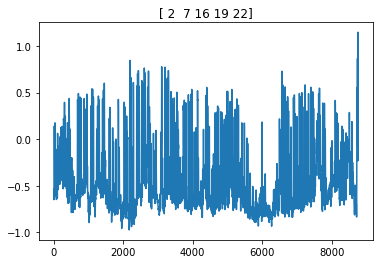

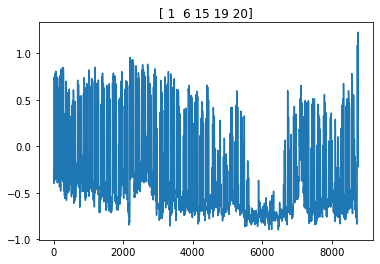

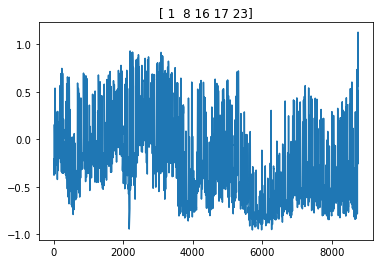

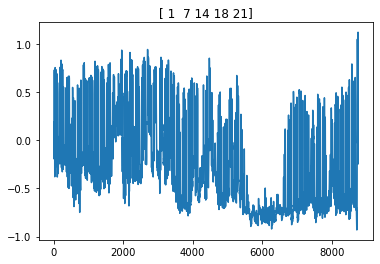

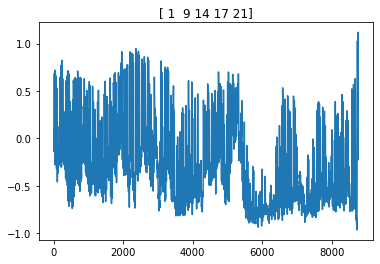

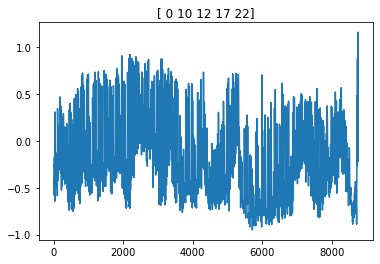

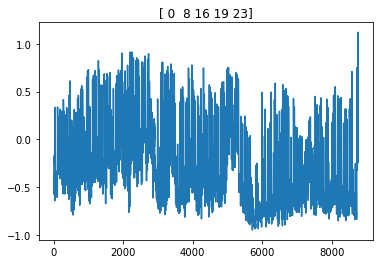

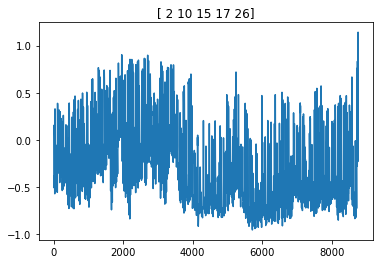

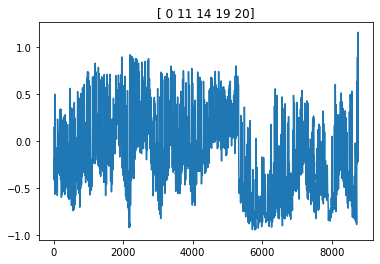

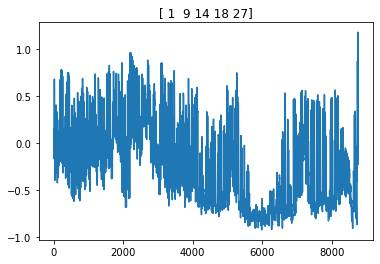

In [11]:
for elec, lb in zip(gen_electrical_data[:10], gen_labels[:10]):
    plt.figure()
    plt.plot(elec[:, 0])
    plt.title(str(lb))

## Trainging the Model

In [22]:
early_stopping_monitor = EarlyStopping(patience=3)
gen_model = create_model()
gen_history = gen_model.fit(gen_train_data, gen_train_labels, batch_size=batch_size, epochs=100, validation_data=(gen_val_data, \
                        gen_val_labels), callbacks=[early_stopping_monitor])

Epoch 1/100
125/125 [==============================] - 8s 46ms/step - loss: 12.2869 - acc: 0.2249 - pr: 0.2250 - rc: 0.2084 - f1: 0.2206 - val_loss: 1.6418 - val_acc: 0.1840 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.0622
Epoch 2/100
125/125 [==============================] - 5s 42ms/step - loss: 2.7445 - acc: 0.2381 - pr: 0.2502 - rc: 0.1349 - f1: 0.2360 - val_loss: 1.7201 - val_acc: 0.2160 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.0852
Epoch 3/100
125/125 [==============================] - 5s 42ms/step - loss: 1.8874 - acc: 0.2327 - pr: 0.2855 - rc: 0.0632 - f1: 0.2292 - val_loss: 1.6062 - val_acc: 0.2400 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.1334
Epoch 4/100
125/125 [==============================] - 5s 42ms/step - loss: 1.7138 - acc: 0.2524 - pr: 0.3705 - rc: 0.0443 - f1: 0.2316 - val_loss: 1.6017 - val_acc: 0.2520 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.1576
Epoch 5/100
125/125 [==============================] - 5s 42ms/step - l

In [25]:
gen_model.save_weights(ckpt_dir + '/gen_weights.ckpt')

## Test the Model

### TSTR

In [23]:
gen_model_eval = gen_model.evaluate(test_data, test_labels, batch_size=batch_size)

2/2 [==============================] - 0s 11ms/step - loss: 2.9676 - acc: 0.4000 - pr: 0.6667 - rc: 0.3200 - f1: 0.2055


## Load already computed metrics

In [15]:
rest_metrics = np.load('classif_metrics&evals.npz')

## Show Results

In [27]:
model_eval = rest_metrics['trtr']
wgen_model_eval = rest_metrics['tstr']

In [28]:
print(model_eval)
print(gen_model_eval)
print(wgen_model_eval)

[2.37995219, 0.22, 0.25714287, 0.18000001, 0.21176471716262976]
[2.967557668685913, 0.4000000059604645, 0.6666666865348816, 0.3199999928474426, 0.43243243008133586]
[1.809008, 0.56, 0.61764705, 0.41999999, 0.49999999002267564]


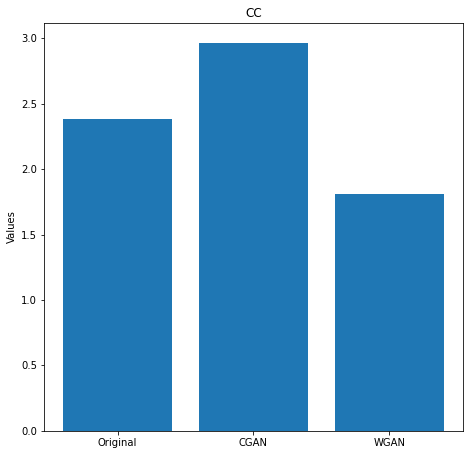

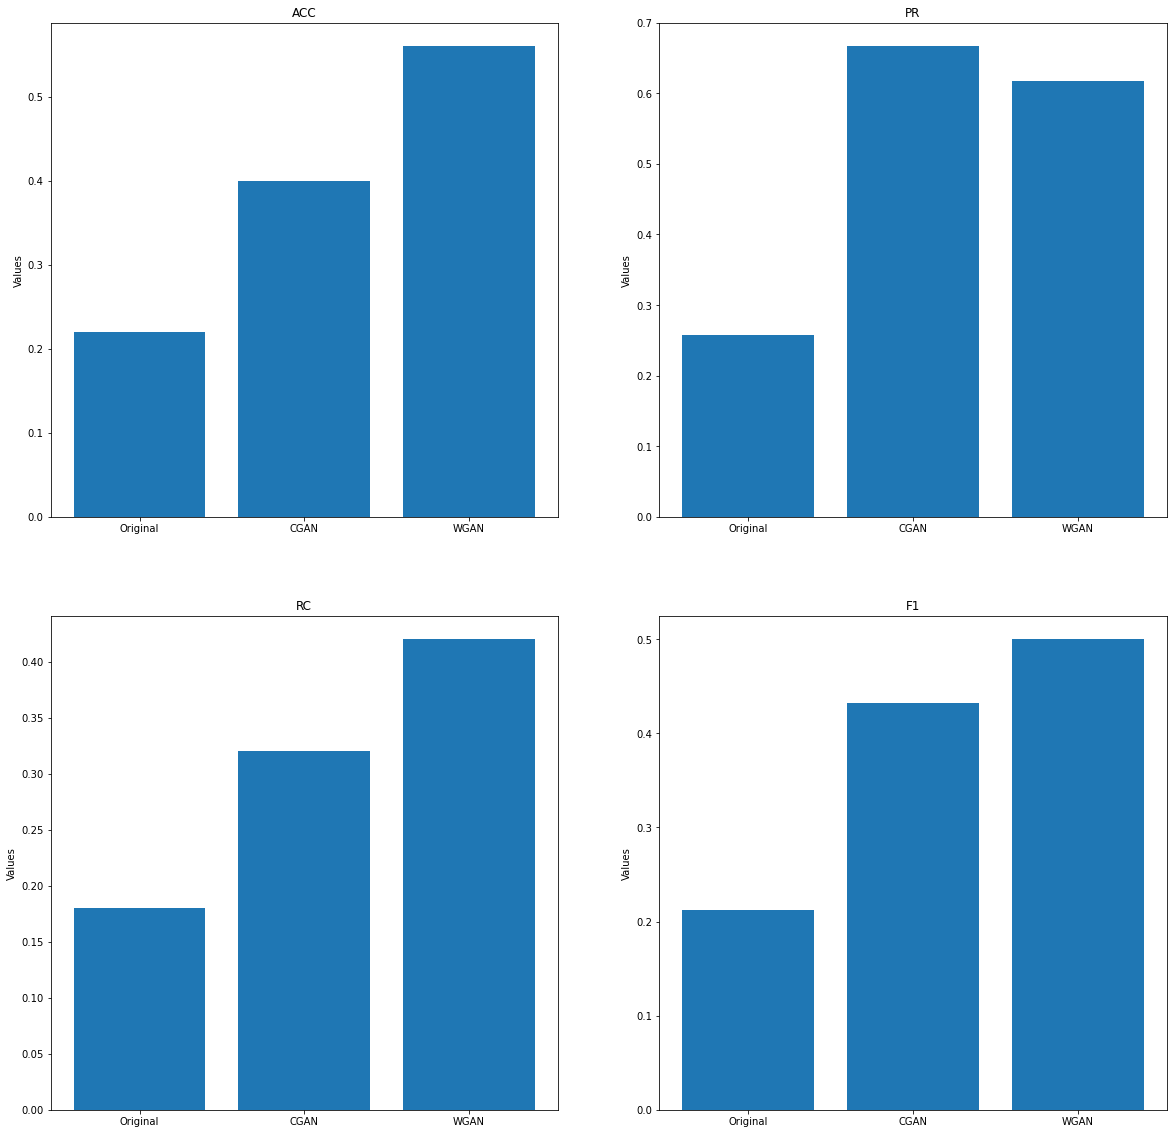

In [31]:
fig = plt.figure()
fig.set_size_inches(7.5, 7.5)
plt.bar(['Original', 'CGAN', 'WGAN'], [model_eval[0], gen_model_eval[0], wgen_model_eval[0]])
plt.title('CC')
plt.ylabel('Values')
plt.show()

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20, 20)
for i, metric in enumerate(['acc', 'pr', 'rc', 'f1'], 1):
    ax = axs[(i - 1) // 2, (i - 1) % 2]
    ax.bar(['Original', 'CGAN', 'WGAN'], [model_eval[i], gen_model_eval[i], wgen_model_eval[i]])
    ax.title.set_text(metric.upper())
    ax.set_ylabel('Values')